In [33]:
import pandas as pd
import numpy as np
import optuna
from langcodes import standardize_tag, Language
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [46]:
dataname = "data/data_1000"
detectors = [
    "Mediapipe",
    "Langdetect",
    "LID-176",
    "OpenLID-201",
    "NLLB-LID-218",
    "GlotLID-v3"
]

df = pd.read_parquet(f"{dataname}-predicted.parquet", engine="pyarrow")
df

,url,text,language_code,language_name,Mediapipe_lang,Mediapipe_score,Langdetect_lang,Langdetect_score,LID-176_lang,LID-176_score,OpenLID-201_lang,OpenLID-201_score,NLLB-LID-218_lang,NLLB-LID-218_score,GlotLID-v3_lang,GlotLID-v3_score
0,https://uk.wikipedia.org/wiki/Monophyllus_plet...,Monophyllus plethodon — вид родини листконосов...,uk,Ukrainian,uk,0.523255,et,0.571427,uk,0.945717,ukr_Cyrl,0.971312,ukr_Cyrl,0.867906,ukr_Cyrl,0.938112
1,https://uk.wikipedia.org/wiki/Monophyllus_plet...,"Країни поширення: Ангілья, Антигуа і Барбуда, ...",uk,Ukrainian,uk,0.928728,uk,1.000000,uk,0.993254,ukr_Cyrl,0.999211,ukr_Cyrl,0.993482,ukr_Cyrl,0.999950
2,https://uk.wikipedia.org/wiki/Monophyllus_plet...,Лаштує сідала в печерах.\n,uk,Ukrainian,uk,0.990120,uk,0.999999,uk,0.996898,ukr_Cyrl,0.999980,ukr_Cyrl,0.999714,ukr_Cyrl,1.000005
3,https://uk.wikipedia.org/wiki/Monophyllus_plet...,Гірничодобувна промисловість і туризм в печера...,uk,Ukrainian,uk,0.999136,uk,0.999998,uk,0.997084,ukr_Cyrl,0.999992,ukr_Cyrl,0.999993,ukr_Cyrl,0.998259
4,https://vi.wikipedia.org/wiki/Melipotis_producta,Melipotis producta là một loài bướm đêm trong ...,vi,Vietnamese,vi,0.968102,vi,0.999998,vi,0.999921,vie_Latn,1.000010,vie_Latn,1.000010,vie_Latn,1.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,https://lmo.wikipedia.org/wiki/Sistema_bibliot...,El gh'ha trè sed in del Municipi 1 (oltra a la...,lmo,Lombard,it,0.733396,it,0.714282,it,0.353847,lmo_Latn,0.994759,lmo_Latn,0.924849,lmo_Latn,0.975529
3644,https://lmo.wikipedia.org/wiki/Sistema_bibliot...,Oltra a 'sti sed chi el gh'ha trii deposit.\n,lmo,Lombard,ro,0.327629,it,0.999995,lmo,0.161809,lmo_Latn,1.000010,lmo_Latn,0.990521,lmo_Latn,1.000008
3645,https://lmo.wikipedia.org/wiki/Sistema_bibliot...,Altri progetti,lmo,Lombard,it,0.961547,it,0.999996,it,0.987134,ita_Latn,0.989593,ita_Latn,0.999914,ita_Latn,0.999518
3646,https://awa.wikipedia.org/wiki/%E0%A4%9B%E0%A4...,"छर्रा, भारत देश के उत्तर प्रदेश प्रान्त के अली...",awa,Awadhi,ne,0.883867,hi,0.999998,hi,0.917160,awa_Deva,1.000010,hin_Deva,0.988221,awa_Deva,1.000010


In [79]:
df['language_code'].value_counts()

language_code
eu     98
pwn    84
skr    84
hu     83
tyv    77
       ..
gan     1
hi      1
tk      1
yue     1
kcg     1
Name: count, Length: 307, dtype: int64

In [47]:
# Standardize
columns_to_standardize = ["language_code"] + list(map(lambda x: f"{x}_lang", detectors))
print("Columns to standardize", columns_to_standardize)

def stnd(x):
    if x is None:
        return None

    if x == "simple":
        return "en"  

    if x == "zh-classical":
        return "zh"  
    return Language.get(x).language

for col in columns_to_standardize:
    df[col] = df[col].apply(stnd)
df

Columns to standardize ['language_code', 'Mediapipe_lang', 'Langdetect_lang', 'LID-176_lang', 'OpenLID-201_lang', 'NLLB-LID-218_lang', 'GlotLID-v3_lang']


,url,text,language_code,language_name,Mediapipe_lang,Mediapipe_score,Langdetect_lang,Langdetect_score,LID-176_lang,LID-176_score,OpenLID-201_lang,OpenLID-201_score,NLLB-LID-218_lang,NLLB-LID-218_score,GlotLID-v3_lang,GlotLID-v3_score
0,https://uk.wikipedia.org/wiki/Monophyllus_plet...,Monophyllus plethodon — вид родини листконосов...,uk,Ukrainian,uk,0.523255,et,0.571427,uk,0.945717,uk,0.971312,uk,0.867906,uk,0.938112
1,https://uk.wikipedia.org/wiki/Monophyllus_plet...,"Країни поширення: Ангілья, Антигуа і Барбуда, ...",uk,Ukrainian,uk,0.928728,uk,1.000000,uk,0.993254,uk,0.999211,uk,0.993482,uk,0.999950
2,https://uk.wikipedia.org/wiki/Monophyllus_plet...,Лаштує сідала в печерах.\n,uk,Ukrainian,uk,0.990120,uk,0.999999,uk,0.996898,uk,0.999980,uk,0.999714,uk,1.000005
3,https://uk.wikipedia.org/wiki/Monophyllus_plet...,Гірничодобувна промисловість і туризм в печера...,uk,Ukrainian,uk,0.999136,uk,0.999998,uk,0.997084,uk,0.999992,uk,0.999993,uk,0.998259
4,https://vi.wikipedia.org/wiki/Melipotis_producta,Melipotis producta là một loài bướm đêm trong ...,vi,Vietnamese,vi,0.968102,vi,0.999998,vi,0.999921,vi,1.000010,vi,1.000010,vi,1.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,https://lmo.wikipedia.org/wiki/Sistema_bibliot...,El gh'ha trè sed in del Municipi 1 (oltra a la...,lmo,Lombard,it,0.733396,it,0.714282,it,0.353847,lmo,0.994759,lmo,0.924849,lmo,0.975529
3644,https://lmo.wikipedia.org/wiki/Sistema_bibliot...,Oltra a 'sti sed chi el gh'ha trii deposit.\n,lmo,Lombard,ro,0.327629,it,0.999995,lmo,0.161809,lmo,1.000010,lmo,0.990521,lmo,1.000008
3645,https://lmo.wikipedia.org/wiki/Sistema_bibliot...,Altri progetti,lmo,Lombard,it,0.961547,it,0.999996,it,0.987134,it,0.989593,it,0.999914,it,0.999518
3646,https://awa.wikipedia.org/wiki/%E0%A4%9B%E0%A4...,"छर्रा, भारत देश के उत्तर प्रदेश प्रान्त के अली...",awa,Awadhi,ne,0.883867,hi,0.999998,hi,0.917160,awa,1.000010,hi,0.988221,awa,1.000010


,detector,accuracy,better_than_glot
0,Mediapipe,0.335252,0.041667
1,Langdetect,0.210526,0.018092
2,LID-176,0.427906,0.053180
3,OpenLID-201,0.448191,0.015625
4,NLLB-LID-218,0.460252,0.015351
5,GlotLID-v3,0.729441,0.000000


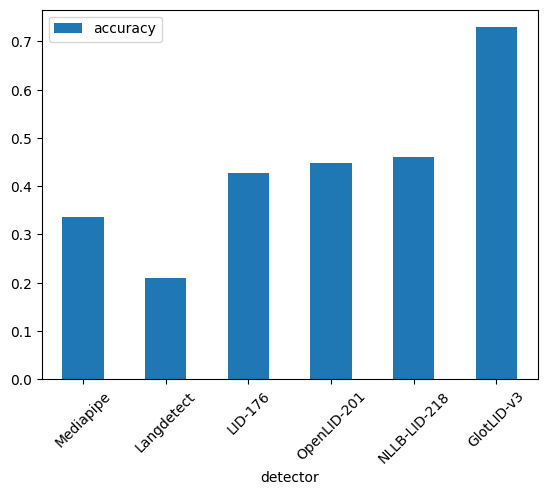

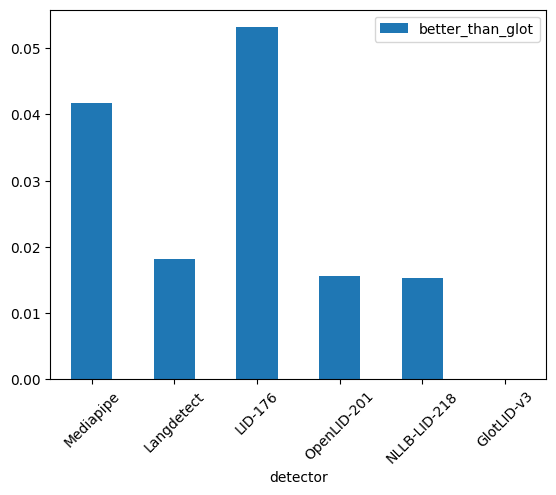

In [70]:
accuracies = []
for detector in detectors:
    df[f"{detector}_correct"] = df[f"{detector}_lang"] == df["language_code"]
    df[f"{detector}_better_than_glot"] = (df[f"{detector}_lang"] == df["language_code"]) & (df[f"GlotLID-v3_lang"] != df["language_code"])

    accuracies.append({
        "detector" : detector, 
        "accuracy": sum(df[f"{detector}_correct"]) / len(df),
        "better_than_glot": sum(df[f"{detector}_better_than_glot"]) / len(df)
    })
df_accuracies = pd.DataFrame(accuracies)
df_accuracies.plot.bar(x="detector", y="accuracy", rot=45)
df_accuracies.plot.bar(x="detector", y="better_than_glot", rot=45)
df_accuracies

In [76]:
df[df["LID-176_better_than_glot"]][["text", "language_code", "LID-176_lang", "LID-176_score", "GlotLID-v3_lang", "GlotLID-v3_score"]]

,text,language_code,LID-176_lang,LID-176_score,GlotLID-v3_lang,GlotLID-v3_score
22,1486 wataqa Hulyanu kalindaryukama intichawwan...,qu,qu,0.455470,quy,0.329836
46,Аваран хъишлах ·\nАгъа Калунхуьр ·\nАгъа Лак...,lez,lez,0.419106,qve,0.309639
58,Gerb • Bayraq • Himn • Dövlət quruluşu • Konst...,az,az,0.989988,azj,0.999234
61,I J.R.R. Tolkiens Midgard er lembas en type br...,no,no,0.890238,nb,0.999968
114,Опел Агила нь миниван загварын автомашин бөгөө...,mn,mn,0.988129,khk,0.998387
...,...,...,...,...,...,...
3599,Do teritorijalne reorganizacije u Hrvatskoj na...,bs,bs,0.592625,hr,0.568073
3600,"Na popisu stanovništva 2011. godine, Markoci s...",bs,bs,0.713783,hr,0.669122
3602,"Na popisu stanovništva 1991. godine, naseljeno...",bs,bs,0.803766,hr,0.948939
3604,崇侯虎，為有崇氏之君，侯爵，諱虎。受商封為侯，是其重翼也。時商紂時，紂為政殘虐，謂民於炮烙。...,zh,zh,0.919431,cmn,0.781317
